# Introduction to Geospatial AI

# Intro
Welcome to this workshop about geospatial AI! In this workshop you will try to detect buildings from aerial images. This is done in three steps;

1. Create training data. We have two different sources of data; A WMS containing aerial images and an OpenStreetMap database to get the locations of buildings.
2. Training machine learning models using the training data.
3. Evaluating the trained models and predicting where buildings are located in images the models haven't seen before.

We will be using jupyter notebooks with Google Colab, but you don't need to have any experience with these in order to complete this workshop.

# Task 0.0 - Select GPU env

But first, we need to change the runtime to a GPU. In the top right corner click the "triangle" and choose `Change runtime type` and select `T4 GPU`.

Run cell below to confirm selected runtime

In [4]:
import tensorflow as tf

gpus_or_tpus_available = len(tf.config.list_physical_devices('GPU'))
if gpus_or_tpus_available < 1:
  raise ValueError("ERROR: Wrong runtime detected. Change runtime in top right corner to T4 GPU before running cell again")
else:
  print("Environment confirmed - continue to next task!")

Environment confirmed - continue to next task!


# Task 0.1 - Add secrets
We now need to insert secrets, in order to access the different data we need.

1. Go to the github gist (where you found the link to this notebook)
2. Insert the secrets in the next cell and run it.

In [7]:
import os
os.environ['NK_WMS_API_KEY'] = "7BC67FFD-2C16-45A2-B5D3-889D639321AF"
os.environ['OSM_DB_PWD'] = "1{65Eb?R-3q>"
azure_table_sas_token = "sv=2024-11-04&ss=bft&srt=sco&sp=rwdlacuiytfx&se=2026-08-31T20:52:22Z&st=2025-03-25T13:52:22Z&spr=https&sig=Q52pmA524hAJohPH2zLz7rKvoyVEUoHI0qTckhi2K9g%3D"

# Task 0.2 - Setup project

Next, we need to clone the git repo we are working with and install some dependencies.

All you need to do is run cell:

In [8]:
import tensorflow as tf
#Check correct runtime before installing dependencies
if len(tf.config.list_physical_devices('GPU')) < 1:
  raise ValueError("ERROR: Wrong runtime detected. Change runtime in top right corner to T4 GPU before running cell again")

if not (os.environ['NK_WMS_API_KEY'] and os.environ['OSM_DB_PWD'] and azure_table_sas_token):
  raise ValueError("ERROR: Missing environment variables. Please go back to previous task.")


#Install dependencies
!git clone https://github.com/kartAI/kartAI.git
!git -C /content/kartAI/ checkout origin/workshop env.py

!pip install focal_loss
!pip install azure-storage-blob
!pip install rasterio
!pip install rasterstats
!pip install colour
!pip install azure-data-tables
!pip install azure-core


import sys
import os
import random
import string

sys.path.insert(0,'/content/kartAI')
table_name = 'abakus'
partition_key = 'kartAI'
row_key = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
max_iou = 0

Cloning into 'kartAI'...
remote: Enumerating objects: 1197, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1197 (delta 84), reused 69 (delta 69), pack-reused 1034 (from 2)
Receiving objects: 100% (1197/1197), 1.86 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (798/798), done.
Updated 1 path from 916a21a
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.1/207.1 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 8.6 MB/s eta 0:00:00


In [31]:
!wget https://raw.githubusercontent.com/kartAI/kartAI/master/training_data/regions/KristiansandBorderCropped.json


--2025-04-07 10:08:17--  https://raw.githubusercontent.com/kartAI/kartAI/master/training_data/regions/KristiansandBorderCropped.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278182 (272K) [text/plain]
Saving to: ‘KristiansandBorderCropped.json’

KristiansandBorderC 100%[===================>] 271.66K  --.-KB/s    in 0.004s  

2025-04-07 10:08:18 (70.3 MB/s) - ‘KristiansandBorderCropped.json’ saved [278182/278182]



# Task 0.3 - Choose a scoreboard nickname

In this workshop there is a scoreboard to show who trains the best model. Insert your nickname in the cell under which will appear on the scoreboard along with the score for your best trained model. Eternal glory awaits for the individual who trains the best model...

In [9]:
epic_scoreboard_nickname = "Airbender2"

# Task 1.1 - Select your training dataset

Your first task is to select which area you want to create training data for.

1. Select a name for your area by changing the variable `training_dataset_name`
2. Choose an area by uncommenting the code for one of our three predefined areas

In [34]:
# Set the name of your training set
training_dataset_name = "best_training_dataset"

# Jeg velger Skøyen, Oslo:
area = {
    "x_min": 593150.9,
    "x_max": 596528.0,
    "y_min": 6643812.3,
    "y_max": 6644452.2
}

try:
  print(f"Woho!\nSelected area {area} with name {training_dataset_name}")
except:
  print("ERROR! \nYou have not selected one of the areas to create data for.")



Woho!
Selected area {'x_min': 593150.9, 'x_max': 596528.0, 'y_min': 6643812.3, 'y_max': 6644452.2} with name best_training_dataset


In [5]:
!wget https://raw.githubusercontent.com/kartAI/kartAI/master/training_data/regions/KristiansandBorderCropped.json


--2025-04-07 10:45:43--  https://raw.githubusercontent.com/kartAI/kartAI/master/training_data/regions/KristiansandBorderCropped.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278182 (272K) [text/plain]
Saving to: ‘KristiansandBorderCropped.json’

KristiansandBorderC 100%[===================>] 271.66K  --.-KB/s    in 0.004s  

2025-04-07 10:45:43 (64.2 MB/s) - ‘KristiansandBorderCropped.json’ saved [278182/278182]



# Task 1.2 - Create training data
Your next task is to create training data for your selected area.

The training data is downloaded as rasters (images) and added to a new directory called "training_data", that can be seen in the directory menu on the left. The data is split into training, validation and test.

While downloading the rasters, it will say how many rasters that will be downloaded in total.
The process is time consuming, and will take around 10 minutes.

In [35]:
from kartAI.kartai.tools.create_training_data import create_training_data
import shutil

# Slett gamle treningsdata
try:
    shutil.rmtree("/content/training_data")
except FileNotFoundError:
    pass

# Lag nye treningsdata
create_training_data(
    training_dataset_name=training_dataset_name,
    config_file_path="kartAI/config/dataset/osm_bygg.json",
    eager_load=True,
    confidence_threshold=None,
    eval_model_checkpoint=None,
    region=None,
    x_min=area["x_min"],
    x_max=area["x_max"],
    y_min=area["y_min"],
    y_max=area["y_max"],
    num_processes=None
)


-------creating dataset ------- 
 name: best_training_dataset
301 208
feature count:  15


/content/kartAI/kartai/datamodels_and_services/DatasetBuilder.py:128: RuntimeWarning: overflow encountered in scalar add
  frac_sum += np_band[i, j]


request status is 200

Added to dataset, total instances: 1 of 245
302 208
feature count:  17
request status is 200

Added to dataset, total instances: 2 of 245
303 208
feature count:  27
request status is 200

Added to dataset, total instances: 3 of 245
304 208
feature count:  23
request status is 200

Added to dataset, total instances: 4 of 245
305 208
feature count:  14
request status is 200

Added to dataset, total instances: 5 of 245
306 208
feature count:  4
request status is 200

Added to dataset, total instances: 6 of 245
307 208
feature count:  2
request status is 200

Added to dataset, total instances: 7 of 245
308 208
feature count:  7
request status is 200

Added to dataset, total instances: 8 of 245
309 208
feature count:  6
request status is 200

Added to dataset, total instances: 9 of 245
310 208
feature count:  4
request status is 200

Added to dataset, total instances: 10 of 245
311 208
feature count:  6
request status is 200

Added to dataset, total instances: 11 of 2

'training_data/created_datasets/best_training_dataset'

In [30]:
import json
from kartAI.kartai.datamodels_and_services.Region import Region

# Last inn JSON og konverter til Region-objekt
with open("KristiansandBorderCropped.json", "r") as f:
    region_json = json.load(f)

region = Region.from_json(region_json)  # ✅ konvertering


FileNotFoundError: [Errno 2] No such file or directory: 'KristiansandBorderCropped.json'

In [1]:
!git clone https://github.com/kartAI/kartAI.git
%cd kartAI
!pip install -r requirements.txt
!pip install azure-storage-blob



fatal: destination path 'kartAI' already exists and is not an empty directory.
/content/kartAI
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Slett gammel versjon av kartAI hvis den finnes
!rm -rf kartAI

# Klon prosjektet på nytt
!git clone https://github.com/kartAI/kartAI.git
%cd kartAI

# Installer avhengigheter
!pip install -r requirements.txt
!pip install azure-storage-blob


Cloning into 'kartAI'...
remote: Enumerating objects: 1197, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1197 (delta 84), reused 69 (delta 69), pack-reused 1034 (from 2)
Receiving objects: 100% (1197/1197), 1.85 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (798/798), done.
/content/kartAI/kartAI
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [4]:
!pip install azure-storage-blob geopandas rasterio shapely pyproj


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.7 MB/s eta 0:00:00


# Task 1.3 - Visualize training data
After downloading the data you can visualize it in the next cell.


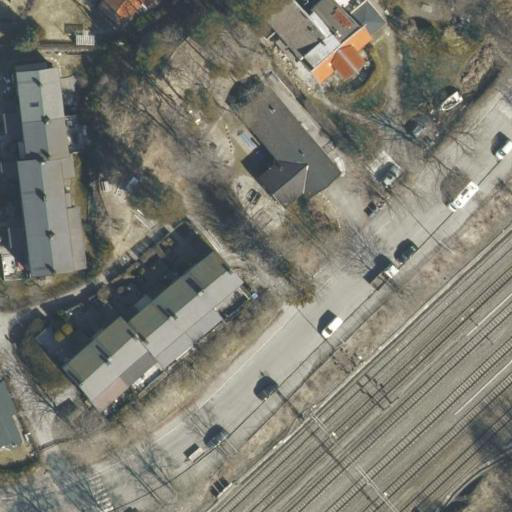
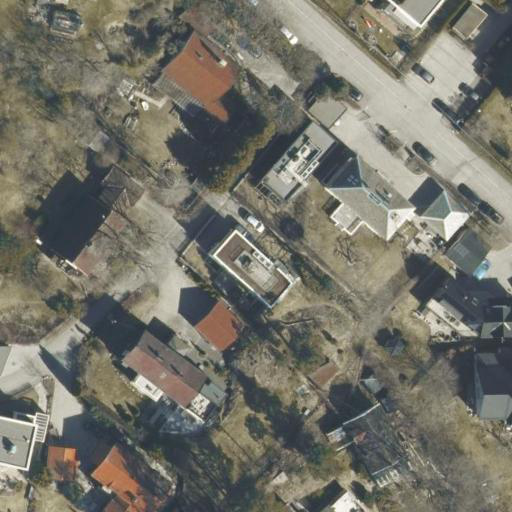
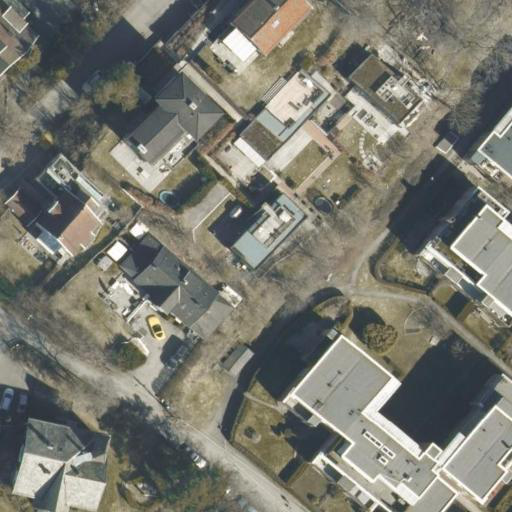
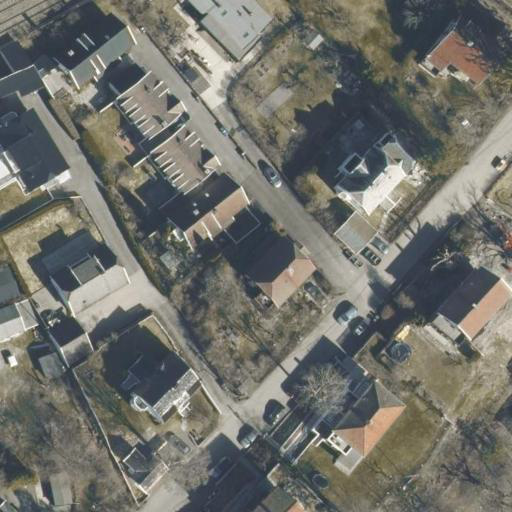
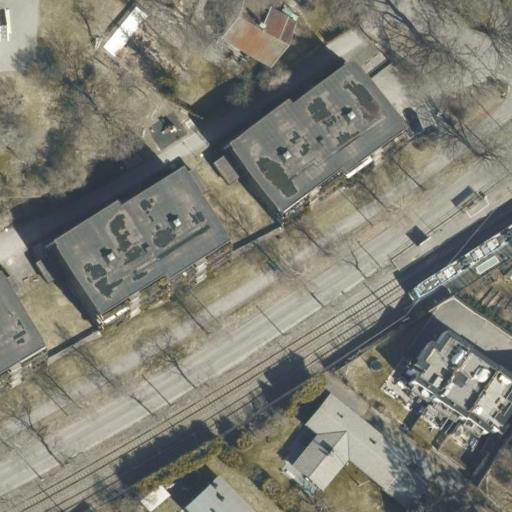

In [38]:
import folium
import rasterio
import os
from pyproj import CRS, Transformer

# Riktig sti til dine treningsdata
path_to_dir = "/content/training_data/OrtofotoWMS/25832_563000.0_6623000.0_100.0_100.0/512/"
files = os.listdir(path_to_dir)
files.sort()

# Koordinatsystemer
crs_25832 = CRS.from_epsg(25832)
crs_4326 = CRS.from_epsg(4326)
transformer = Transformer.from_crs(crs_25832, crs_4326)

# Startkart – bruk første bilde sin toppvenstre hjørne
with rasterio.open(f"{path_to_dir}{files[0]}") as src:
    x_start, y_start = transformer.transform(src.bounds.left, src.bounds.top)

fig = folium.Figure(width=800, height=400)
m = folium.Map(location=(x_start, y_start), zoom_start=14)

# Legg til 5 fliser som bildeoverlegg
for i in range(5):
    with rasterio.open(f"{path_to_dir}{files[i]}") as src:
        img = src.read()
        bounds = src.bounds
        bottom_left = transformer.transform(bounds.left, bounds.bottom)
        top_right = transformer.transform(bounds.right, bounds.top)
        m.add_child(folium.raster_layers.ImageOverlay(
            img.transpose(1, 2, 0),
            bounds=[bottom_left, top_right]
        ))

fig.add_child(m)



In [37]:
!ls /content/training_data/OrtofotoWMS/


25832_563000.0_6623000.0_100.0_100.0


# Task 2.1 - Choose model type and hyperparameters
After creating and visualizing the training data we are ready to train our model! Before we start training the model we need to decide what kind of model you want to build. Give your model a name and choose hyperparameters you want to work with.

The `model` argument below decides what kind of model architecture you want to use. The supported ones are
 - `unet`. The “U-Net” architecture consists of 2 parts: the first part is a “classic” Convolutional Neural Network which scans the image, extract patterns from it, and combine them into high resolutions features. Then, the network is asked to upscale its hidden layers into recreating a full binary image, where each pixel is either 0 or 1.
 - `resnet`. Residual Network (ResNet) architecture is a type of artificial neural network that allows the model to skip layers without affecting performance and therefore circumventing the vanishing gradient problem.
 - `CSP`. A Cross Stage Partial (CSP) block is designed to attribute the problem of duplicate gradient information within network optimization. The input is split into two paths, where one path is goes through a dense block, while the other skips the block and joins at the end. This means complexity can be reduced while maintaining the accuracy.

If you want to know more about the models and their architecture feel free to ask us or google them!

In [43]:
model_name = "skoyen_unet_v1"
model_architecture = "unet"

train_args = {
      "features": 32,
      "depth": 4,
      "optimizer": "RMSprop",
      "batch_size": 8,
      "model": model_architecture,
      "loss": "binary_crossentropy",
      "activation": "relu",
      "epochs": 20
}



In [41]:
!find /content/kartAI -name "train_model.py"


# Task 2.2 - Train your own machine learning model
The models you're about to train performs what is known as a per-pixel classification. In other words, the model tries to assign a class (either a building or not a building) for each pixel in the raster based on the input features. After the model is trained we can create vector data from the predicted pixels and therefore end up with bounding boxes we can look at!

In the next cell you can tune some hyperparameters, but make sure the training doesn't take too long. The default configuration should take about ~15 minutes to execute and should get you a _decent_ model.

While training, the terminal will print some statistics. These can be a little bit confusing, and it's not a must to understand all of them. The stats showing are;

 - Loss: A measurement of how wrong the model is. The lower the loss is, the better. If the loss is 0, the model is "perfect". A model tries to minimize this value.
 - Binary Accuracy: A measurement of how many of the predicted pixels are inside a building. It's a number between 0 and 1, where higher is better. 1 means all the pixels the model says are within a building is actually within a building. But keep in mind even if the number is 1, the model might not have made predictions for all pixels in all buildings...
 - IoU: Intersection over Union. A measurement of how much of the estimated area overlaps with a building. It's a number between 0 and 1, where higher is better. 1 means the model is fitting the bounding box of all buildings "perfectly".
 - IoU_fz: Fuzzy set variant of IoU. Shares similar characteristics as described earlier.
 - IoU_point_[5-9]: Cutoff values for IoU. It's a measurement of what the IoU would be if the cutoff values was [5-9].
 - val_x: The validation equivalent of whatever x is. X could be loss, IoU, etc.

In [44]:
# Sørg for at alt er importert
from kartAI.kartai.tools.train import train

# Modellnavn og arkitektur
model_name = "skoyen_unet_v1"
model_architecture = "unet"

# Hyperparametere for trening
train_args = {
    "features": 32,
    "depth": 4,
    "optimizer": "RMSprop",
    "batch_size": 8,
    "model": model_architecture,
    "loss": "binary_crossentropy",
    "activation": "relu",
    "epochs": 20
}

# Datasettnavn (husk at dette må matche det du brukte i Task 1.1)
training_dataset_name = "best_training_dataset"  # eller "kristiansand_training_set" hvis det var det du brukte

# Start treningen
train(
    checkpoint_name=model_name,
    dataset_name=[training_dataset_name],
    input_generator_config_path="kartAI/config/ml_input_generator/ortofoto.json",
    save_model=False,  # endre til True hvis du vil lagre i skyen
    train_args=train_args,
    checkpoint_to_finetune=False
)



Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_layer_conv        │ (None, 512, 512, 32)   │            864 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_layer_batchnorm   │ (None, 512, 512, 32)   │            128 │ initial_layer_conv[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_layer_activation  │ (None, 512, 512, 32)   │              0 │ initial_layer_batchno… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_c1_conv (Conv2D) │ (None, 512, 512, 32)   │          9,216 │ initial_layer_activat… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_c1_batchnorm     │ (None, 512, 512, 32)   │            128 │ encoder1_c1_conv[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_c1_activation    │ (None, 512, 512, 32)   │              0 │ encoder1_c1_batchnorm… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_c2_conv (Conv2D) │ (None, 512, 512, 32)   │          9,216 │ encoder1_c1_activatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_c2_batchnorm     │ (None, 512, 512, 32)   │            128 │ encoder1_c2_conv[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_c2_activation    │ (None, 512, 512, 32)   │              0 │ encoder1_c2_batchnorm… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_down_conv        │ (None, 256, 256, 64)   │         18,432 │ encoder1_c2_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_down_batchnorm   │ (None, 256, 256, 64)   │            256 │ encoder1_down_conv[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder1_down_activation  │ (None, 256, 256, 64)   │              0 │ encoder1_down_batchno… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_c1_conv (Conv2D) │ (None, 256, 256, 64)   │         36,864 │ encoder1_down_activat… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder2_c1_batchnorm

 Total params: 26,244,961 (100.12 MB)

 Trainable params: 26,234,465 (100.08 MB)

 Non-trainable params: 10,496 (41.00 KB)

learning_rate 0.001

----SAVE TO: checkpoints/skoyen_unet_v1.keras

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - binary_accuracy: 0.7074 - io_u: 0.2347 - io_u_fz: 0.2347 - iou_point_5: 0.2954 - iou_point_6: 0.2515 - iou_point_7: 0.1950 - iou_point_8: 0.1314 - iou_point_9: 0.0733 - loss: 0.5860
Epoch 1: val_io_u improved from -inf to 0.18112, saving model to checkpoints/skoyen_unet_v1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - binary_accuracy: 0.7103 - io_u: 0.2366 - io_u_fz: 0.2366 - iou_point_5: 0.2986 - iou_point_6: 0.2547 - iou_point_7: 0.1980 - iou_point_8: 0.1336 - iou_point_9: 0.0744 - loss: 0.5822 - val_binary_accuracy: 0.5836 - val_io_u: 0.1811 - val_io_u_fz: 0.1811 - val_iou_point_5: 0.1829 - val_iou_point_6: 0.1488 - val_iou_point_7: 0.1172 - val_iou_point_8: 0.0805 - val_iou_point_9: 0.0317 - val_loss: 0.7425 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - binary_accuracy: 0.8379 - io_u: 0.3289 - io_u_fz: 0.3289 - iou_point_5: 0.4527 - iou_point_6: 0.4113 - iou_point_7: 0.3420 - iou_point_8: 0.2426 - iou_point

# Task 2.3 Upload scores to leaderboard

Run the next cell to upload scores to the leaderboards. No cheating!

In [42]:
import json
from azure.data.tables import TableServiceClient, UpdateMode
from azure.core.credentials import AzureSasCredential
import random
import string

# Definer nødvendig informasjon
table_name = "abakus"
partition_key = "kartAI"
row_key = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
max_iou = 0
epic_scoreboard_nickname = "Airbender2"

# Koble til Azure Table Storage
table_service_client = TableServiceClient(
    endpoint="https://kartaiworkshop.table.core.windows.net",
    credential=AzureSasCredential(azure_table_sas_token)
)
table_client = table_service_client.get_table_client(table_name=table_name)

# Les modellens resultater fra metadatafil
with open(f"checkpoints/{model_name}.meta.json", "r") as metadata:
    metadata_json = json.load(metadata)
    new_max_iou = max(metadata_json['training_results']['val_io_u'])

    if new_max_iou > max_iou:
        table_client.upsert_entity(entity={
            'PartitionKey': partition_key,
            'RowKey': row_key,
            'max_iou': new_max_iou,
            'nickname': epic_scoreboard_nickname,
        }, mode=UpdateMode.REPLACE)
        max_iou = new_max_iou
        print(f"Ny beste IoU ble lastet opp: {max_iou}")
    else:
        print(f"Ingen forbedring. Beste IoU er fortsatt {max_iou}")


Ny beste IoU ble lastet opp: 0.6484191417694092


In [41]:
epic_scoreboard_nickname = "Airbender2"
model_name = "skoyen_unet_v1"  # eller ditt faktiske modellnavn
training_dataset_name = "best_training_dataset"  # eller ditt faktiske datasett
table_name = "Leaderboard"
partition_key = training_dataset_name
row_key = model_name
max_iou = 0.0  # initialverdi


In [51]:
from azure.data.tables import TableServiceClient
from azure.core.credentials import AzureSasCredential
import pandas as pd

# SAS-token og tabell
sas_token = "sv=2024-11-04&ss=bft&srt=sco&sp=rwdlacuiytfx&se=2026-08-31T20:52:22Z&st=2025-03-25T13:52:22Z&spr=https&sig=Q52pmA524hAJohPH2zLz7rKvoyVEUoHI0qTckhi2K9g%3D"
table_name = "abakus"
endpoint = "https://kartaiworkshop.table.core.windows.net"

# Koble til tabellen
service = TableServiceClient(endpoint=endpoint, credential=AzureSasCredential(sas_token))
table_client = service.get_table_client(table_name=table_name)

# Hent og sorter data
rows = table_client.list_entities()
data = [{"nickname": r["nickname"], "IoU": r["max_iou"]} for r in rows]

# Vis topp 10
df = pd.DataFrame(data)
df = df.sort_values(by="IoU", ascending=False).reset_index(drop=True)
df.head(10)



nickname         IoU
0      TESTING TESTING  100.000000
1             gruppe_6    0.667428
2  BirdAI-Robertoguten    0.649155
3           Airbender2    0.648419
4           Airbender2    0.648419
5                 Ivar    0.647257
6              gruppe7    0.645530
7            Gruppe_13    0.644234
8       BirdAI-Roberto    0.637154
9                Terje    0.636774

# Task 3.1 - Running inference on test set
For task 3 we will use our trained machine learning model and try to find buildings in a new set of images we haven't seen so far. The next cell runs predictions on the test portion of the downloaded training data. The same statistics as the ones described during training shows up.

In [46]:
"kartAI/config/ml_input_generator/ortofoto.json"


'kartAI/config/ml_input_generator/ortofoto.json'

In [47]:
training_dataset_name = "best_training_dataset"
model_name = "skoyen_unet_v1"


In [18]:
import os
os.environ["NK_WMS_API_KEY"] = "din_api_nøkkel"  # Erstatt med din API-nøkkel


In [37]:
import os

# Sett miljøvariabler for nødvendige API-nøkler
os.environ['NK_WMS_API_KEY'] = "7BC67FFD-2C16-45A2-B5D3-889D639321AF"  # Erstatt med din API-nøkkel
os.environ['OSM_DB_PWD'] = "1{65Eb?R-3q>"  # Erstatt med ditt passord

# Azure SAS token for tabelltilgang (endret verdi her for eksempel)
azure_table_sas_token = "sv=2024-11-04&ss=bft&srt=sco&sp=rwdlacuiytfx&se=2026-08-31T20:52:22Z&st=2025-03-25T13:52:22Z&spr=https&sig=Q52pmA524hAJohPH2zLz7rKvoyVEUoHI0qTckhi2K9g%3D"



In [45]:
import os
print(os.path.exists("kartAI/config/ml_input_generator/ortofoto.json"))


True


In [44]:
import os
import json
from kartAI.env import get_env_variable
from kartAI.kartai.tools.predict import predict_and_evaluate

# Definer variabler for treningssett og modell
training_dataset_name = "best_training_dataset"  # Erstatt med ditt treningssett-navn
model_name = "skoyen_unet_v1"  # Erstatt med navnet på modellen din

# Sti til opprettet datasett
created_datasets_dir = os.path.join(
    get_env_variable('created_datasets_directory'),
    training_dataset_name
)

# Last inn konfigurasjonen for datageneratoren
with open("kartAI/config/ml_input_generator/ortofoto.json", encoding="utf8") as config:
    datagenerator_config = json.load(config)

# Kjør prediksjonene og evalueringen
predict_and_evaluate(
    created_datasets_path=created_datasets_dir,
    datagenerator_config=datagenerator_config,
    checkpoint_name_to_predict_with=model_name,
    save_prediction_images=True,
    save_diff_images=True,
    generate_metadata=True,
    dataset_to_evaluate="test",  # Evaluering av testsettet
    batch_size=200  # Juster batch-størrelsen om nødvendig
)


ImportError: cannot import name 'blobstorage' from 'azure' (unknown location)

# Task 3.2 - Choose a test area
Now that we have looked at some stats from the predictions, let's look at some images! First, we need to set a name and the coordinates of the centre for the test region.

We have set up three predefined areas to look at:
- Kristiansand.
- Stavanger.
- Bodø.

On the other hand, if you want to set up a custom area to look at you have to do the following;

1. Go to [geojson.io](https://geojson.io/#map=4.33/65.07/7.88) and draw an area (has to be within Norway). The feature collection for your area will appear on the right side. Copy the code - but make sure the drawn area is not too big!
2. Paste the copied feature collection in the "test_feature" variable, and uncomment the line

In [57]:
# TODO: Uncomment (remove the #) for the area you want to use, or create a custom area

# test_region_name = "kristiansand"
# test_region_name = "stavanger"
# test_region_name = "bodo"

# Custom area: Kvadraturen i Kristiansand sentrum
test_region_name = "kvadraturen_kristiansand"

test_feature = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [8.0005, 58.1475],
                        [8.0185, 58.1475],
                        [8.0185, 58.1385],
                        [8.0005, 58.1385],
                        [8.0005, 58.1475]
                    ]
                ]
            }
        }
    ]
}

test_latlon_center = [58.1430, 8.0095]


# Task 3.3 - Create vector data
In the next cell we download a different set of rasters and perform predictions on these. After the predictions are made, we create vector data based on the predictions. The vector data generated can be used to visualize our predictions in a map to see how the model is performing.

In [4]:
!pip install azure-storage-blob


In [9]:
from kartAI.kartai.dataset.create_polygon_dataset import produce_vector_dataset, run_ml_predictions
from kartAI.kartai.utils.config_utils import read_config
from kartAI.kartai.utils.crs_utils import get_projection_from_config_path
from kartAI.kartai.utils.geometry_utils import parse_region_arg, parse_feature_region
from kartAI.kartai.utils.prediction_utils import get_raster_predictions_dir, get_vector_predictions_dir
import copy

# Hent geometri fra test_feature eller fra forhåndsdefinert region
if test_feature:
    geom = parse_feature_region(copy.deepcopy(test_feature["features"][0]), from_CRS=4326, swap_coords=True)
    test_region_name = "custom_area"
    print("geom:", geom)
else:
    try:
        geom = parse_region_arg(f"kartAI/training_data/regions/{test_region_name}.json")
    except:
        print("ERROR! Missing test_region_name or test_feature from the previous cell.")

# Last inn konfigurasjon og projeksjon
config_path = "kartAI/config/dataset/osm_bygg_no_rules.json"
projection = get_projection_from_config_path(config_path)
config = read_config(config_path)

# Kjør prediksjoner på området
run_ml_predictions(
    input_model_name=model_name,
    region_name=test_region_name,
    projection=projection,
    config=config,
    geom=geom,
    batch_size=2,
    skip_data_fetching=False,
    save_to="local",
    num_processes=1
)

# Generer vektordata fra rasterprediksjoner
vector_output_dir = get_vector_predictions_dir(test_region_name, model_name)
raster_predictions_path = get_raster_predictions_dir(test_region_name, model_name)

produce_vector_dataset(
    output_dir=vector_output_dir,
    raster_dir=raster_predictions_path,
    config=config,
    max_batch_size=200,
    modelname=f"{test_region_name}_{model_name}",
    save_to="local"
)

print("Ferdig! Vektordata er generert og lagret.")


ModuleNotFoundError: No module named 'azure.blobstorage'

In [7]:
!pip install azure-storage-blob


# Task 3.4 - Visualize vector data
The next cell visualizes the created vector data in a map.

In [ ]:
import folium
import geopandas as gp
import env

def add_wms_layer(map):
    wms_url = "https://waapi.webatlas.no/wms-orto/"
    folium.raster_layers.WmsTileLayer(url = f"{wms_url}?api_key={env.get_env_variable('NK_WMS_API_KEY')}",
                                  layers = 'ortofoto',
                                  transparent = True,
                                  control = True,
                                  fmt="image/png",
                                  name = 'ortofoto',
                                  overlay = True,
                                  show = True,
                                  ).add_to(map)



polygon_25832 = gp.read_file(f"results/{test_region_name}/{model_name}/vector/raw_predictions_0.json")
polygon_4326 = polygon_25832.to_crs(4326)

center_point = polygon_4326.dissolve().to_crs('+proj=cea').centroid.to_crs(4326)

fig = folium.Figure(width=800, height=400)
map = folium.Map(location=(center_point.y[0], center_point.x[0]), zoom_start=14)

add_wms_layer(map)

style = { "color": "#7246C2", "weight": 1, "fillOpacity": 0.5 }
folium.GeoJson(data=polygon_4326["geometry"],
               style_function=lambda x: style
               ).add_to(map)
fig.add_child(map)

# Task 3.5 - Create contour data
Lastly, we create contours. These are similar to the vector data but we can set a cutoff value on how confident the model is that the given area is a building or not. I.e. a contour value of 0.3 means that it will create a polygon around pixels that the model is at least 30% sure is a building, while a contour value of 0.8 creates a polygon around all pixels that the model is 80% sure is a building.

In [ ]:
from kartAI.kartai.dataset.create_polygon_dataset import run_ml_predictions
from kartAI.kartai.tools.predict import create_contour_result
from kartAI.kartai.utils.config_utils import read_config
from kartAI.kartai.utils.crs_utils import get_projection_from_config_path
from kartAI.kartai.utils.geometry_utils import parse_region_arg
from kartAI.kartai.utils.prediction_utils import get_contour_predictions_dir, get_raster_predictions_dir
import copy

if test_feature:
    geom = parse_feature_region(copy.deepcopy(test_feature["features"][0]), from_CRS=4326, swap_coords=True)
    test_region_name = "custom_area"
    print("geom", geom)
else:
  try:
    geom = parse_region_arg(f"kartAI/training_data/regions/{test_region_name}.json")
  except:
    print("ERROR!\Missing test_region_name or a test_feature from your test area in task 3.2")


projection = get_projection_from_config_path("kartAI/config/dataset/osm_bygg_no_rules.json")

config = read_config("kartAI/config/dataset/osm_bygg_no_rules.json")

run_ml_predictions(
    input_model_name=model_name,
    region_name=test_region_name,
    projection=projection,
    config=config,
    geom=geom,
    batch_size=2,
    skip_data_fetching=False,
    save_to="local",
    num_processes=1
)

raster_output_dir = get_raster_predictions_dir(test_region_name, model_name)
contour_output_dir = get_contour_predictions_dir(test_region_name, model_name)

print("---> Creating contour dataset from rasters")

contour_levels = [0.5, 0.8] # Change contour levels here.
create_contour_result(raster_output_dir, contour_output_dir, projection, contour_levels)

print("==== Contour dataset created ====")


# Task 3.6 - Visualize contour data
The last cell visualizes the contours we generated.

In [ ]:
import folium
import geopandas as gp
import math
from colour import Color

contour_25832 = gp.read_file(f"results/{test_region_name}/{model_name}/contour/complete_contour.json")
contour_25832["geometry"] = contour_25832.simplify(tolerance=1)
contour_4326 = contour_25832.to_crs(4326)

center_point = polygon_4326.dissolve().to_crs('+proj=cea').centroid.to_crs(4326)

figure = folium.Figure(width=800, height=400)
map = folium.Map(location=(center_point.y[0], center_point.x[0]), zoom_start=14)

add_wms_layer(map)

style = lambda x: { "color": list(Color("#FFF0F0").range_to(Color("#661100"), 10))[math.floor(x["properties"]["elev"]*10)].hex, "weight": 1.5 }

folium.GeoJson(
    data=contour_4326,
    style_function=style
    ).add_to(map)
figure.add_child(map)

# Congrats!

You have completed the workshop 🚀

If you want, you can go back and choose a different area for training, a different model, change some training parameters etc. – and to see if you can improve the accuracy of your model further!


# Troubleshooting

If you get an out of memory error you can try to run the cell bellow. It won't always work, but it's worth a try ;)
If this doesn't work then you have to restart the workshop.

In [ ]:
import gc

tf.keras.backend.clear_session(free_memory=True)
gc.collect()